In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from led_array.bsccm_utils import *
from image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Show concept of gaussian approximations

In [2]:
N_images = 2000

x2_offset = (3, 0)
photons_per_pixel = 220
# channel = 'DPC_Right'
channel = 'LED119'
intensity_space_max = 100

current_photons_per_pixel = np.mean(load_bsccm_images(bsccm, channel, 50, convert_units_to_photons=True))
photon_fraction = photons_per_pixel / current_photons_per_pixel

x1, x2 = read_images_and_sample_intensities(bsccm, channel, x2_offset, N_images, photon_fraction=photon_fraction, median_filter=True)

100%|██████████| 2000/2000 [00:12<00:00, 156.08it/s]


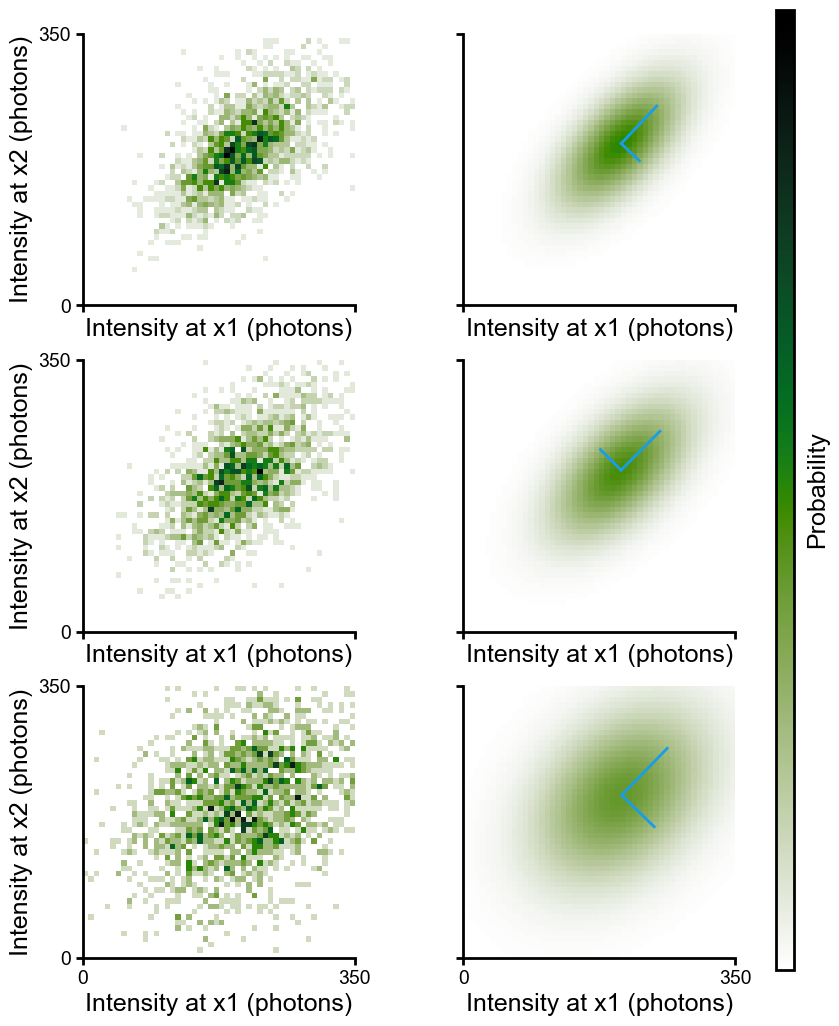

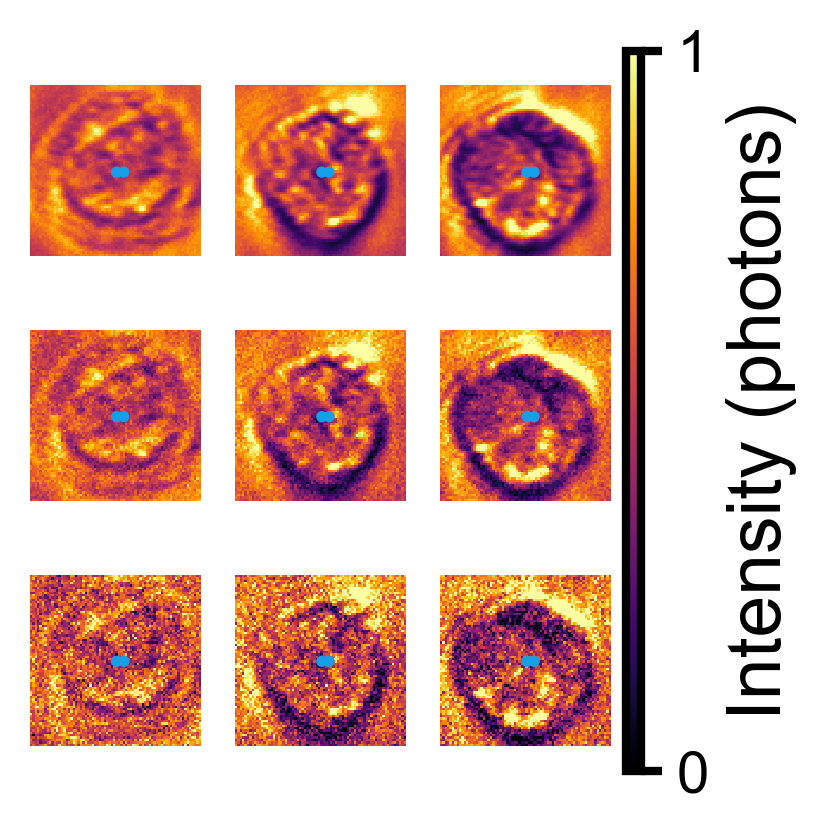

In [3]:
from scipy.stats import multivariate_normal
import cmasher as cmr
from matplotlib.patches import Circle


# display_lim = (30, 80)
display_lim = (0, 350)

num_bins = 50
# cmap =  cmr.torch.reversed()
cmap = cmr.jungle.reversed()

color = get_color_cycle()[0]
# cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), color])


bins = np.linspace(*display_lim, num_bins + 1)

# additive_gaussian_noise = [0]
additive_gaussian_noise = [0, 20, 50]
fig_dist, ax_dist = plt.subplots(len(additive_gaussian_noise), 2, figsize=(9, 4 * len(additive_gaussian_noise)), sharex=True, sharey=True)
fig_img, ax_img = plt.subplots(len(additive_gaussian_noise), 3, figsize=(2.5, 1 * len(additive_gaussian_noise)), dpi=300)


for row_index, gaussian_sigma in enumerate(additive_gaussian_noise):
    noisy_x1 = x1 + onp.random.normal(0, np.sqrt(x1), size=x1.shape)
    noisy_x2 = x2 + onp.random.normal(0, np.sqrt(x2), size=x2.shape)

    noisy_x1 += onp.random.normal(0, gaussian_sigma, size=x1.shape)
    noisy_x2 += onp.random.normal(0, gaussian_sigma, size=x2.shape)

    # plot a a 2d historgram of the design matrix
    p_x, yedges, xedges = np.histogram2d(noisy_x1, noisy_x2, bins=bins)
    p_x /= p_x.sum()

    design = np.stack([noisy_x1, noisy_x2], axis=1)
    # compute mean and covariance
    mean = np.mean(design, axis=0)
    cov = np.cov(design.T)

    gaussian_pdf = multivariate_normal.pdf(np.stack(
        np.meshgrid(np.linspace(*display_lim, num_bins), np.linspace(*display_lim, num_bins)), axis=-1),  mean=mean, cov=cov)
    gaussian_pdf /= gaussian_pdf.sum()

    # compute vmin and vmax for both plots
    vmin = onp.min([p_x, gaussian_pdf])
    vmax = onp.max([p_x, gaussian_pdf])

    # plot a a 2d historgram of the design matrix
    ax_dist[row_index, 0].imshow(p_x, cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
    clear_spines(ax_dist[row_index, 0])
    ax_dist[row_index, 0].set(xticks=display_lim, yticks=display_lim, xlabel='Intensity at x1 (photons)', ylabel='Intensity at x2 (photons)')

    # make another plot showing the PDF of the Gaussian
    ax_dist[row_index, 1].imshow(gaussian_pdf, 
        cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
    # draw the major and minor axes of the ellipse
    eigvals, eigvecs = np.linalg.eigh(cov)
    # plot them
    for eigval, eigvec in zip(np.sqrt(eigvals), eigvecs.T):
        ax_dist[row_index, 1].plot([mean[0], mean[0] +  eigval * eigvec[0]], [mean[1], mean[1] +  eigval * eigvec[1]], color=color, linewidth=2)
    # same formatting as before
    clear_spines(ax_dist[row_index, 1])
    ax_dist[row_index, 1].set(xticks=display_lim, yticks=display_lim, xlabel='Intensity at x1 (photons)')

    # plot example images
    images = np.array([
        load_image_with_synthetic_shot_noise(bsccm, i, channel, photon_fraction=photon_fraction)
         for i in range(3)])

    # now add additional noise for demonstration purposes    
    images += onp.random.normal(0, gaussian_sigma, size=images.shape)
    for i in range(3):
        crop = 28
        cropped_im = images[i][crop:-crop, crop:-crop]
        ax_img[row_index, i].imshow(cropped_im, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
        ax_img[row_index, i].axis('off')
        ax_img[row_index, i].add_patch(Circle((cropped_im.shape[1] // 2, cropped_im.shape[0] // 2), 1.5, color=color))
        ax_img[row_index, i].add_patch(Circle((cropped_im.shape[1] // 2 + x2_offset[0], cropped_im.shape[0] // 2 + x2_offset[1]), 1.5, color=color))    


# add a colorbar
fig_dist.subplots_adjust(right=0.9)
cbar_ax = fig_dist.add_axes([0.92, 0.1, 0.02, 0.8])
fig_dist.colorbar(cm.ScalarMappable(cmap=cmap), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[],  ylabel='Probability')

# add a colorbar
fig_img.subplots_adjust(right=0.9)
cbar_ax = fig_img.add_axes([0.92, 0.1, 0.02, 0.8])
fig_img.colorbar(cm.ScalarMappable(cmap='inferno'), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[0, 1],  ylabel='Intensity (photons)')


fig_dist.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'px_gaussian_approx_gaussian_noise' + '.pdf', transparent=True, dpi=600)
fig_img.savefig('/home/hpinkard_waller/figures/intro_slides/' + 'three_example_images_gaussian_noise' + '.pdf', transparent=True, dpi=600)



100%|██████████| 20000/20000 [00:00<00:00, 913463.35it/s]


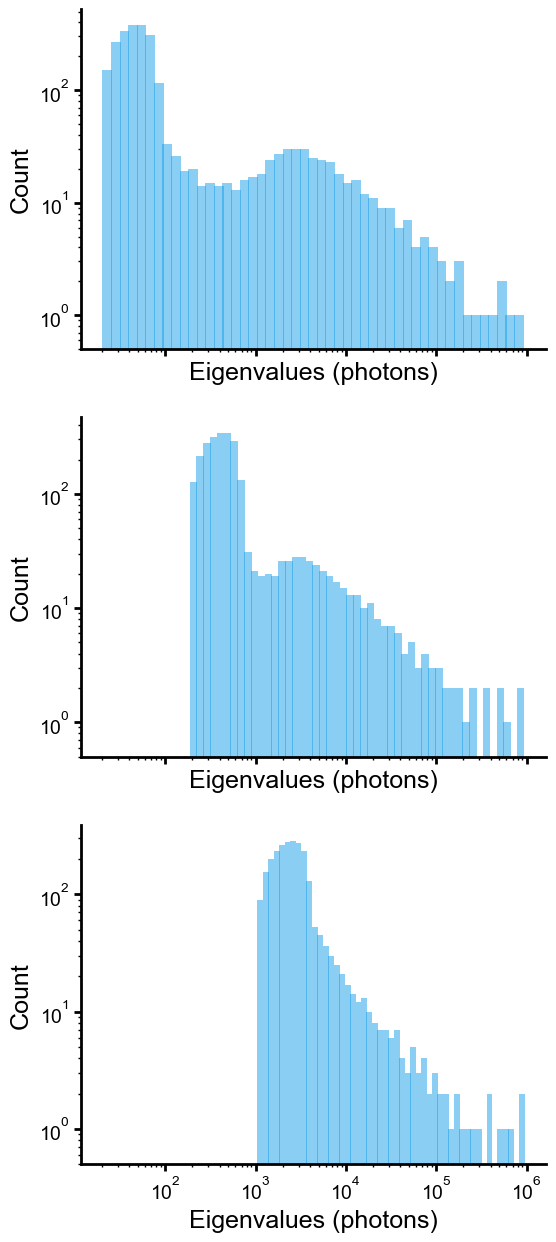

In [4]:
num_images = 1000
patch_size = 50
num_patches = 20000
color = get_color_cycle()[0]

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
images = add_shot_noise_to_experimenal_data(images, photon_fraction=photon_fraction)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

fig, ax = plt.subplots(3, 1, figsize=(6, 5 * len(additive_gaussian_noise)), sharex=True)

bins = None
for i, noise_level in enumerate(additive_gaussian_noise):
    noisy_patches = patches + noise_level * onp.random.randn(*patches.shape)
    values = compute_eigenvalues(noisy_patches)
    # plot the eigenvalue spectrum
    h = OverlayedHistograms(ax=ax[i])
    h.add(values)
    h.plot(color=color)
    bins = h.bins
    ax[i].set(xlabel='Eigenvalues (photons)', ylabel='Count')
    # , xlim=[20, 1e7])
    clear_spines(ax[i])

fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_different_gaussian_noise' + '.pdf', transparent=True)

## 